In [1]:
import sys
import os
import json
import numpy as np
import pandas as pd
from importlib import import_module
import matplotlib.pyplot as plt
from types import MethodType

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import seaborn as sns


# Add the parent directory to the Python path
sys.path.append(os.path.abspath('..')) # if this script is in a subdirectory

# Load TVAE modules
from tvae.tvae_wrapper import TVAESynthesizer, LossValuesMixin
from tvae.data_loader import load_csvs

# Load SDV modules
from sdv.metadata import Metadata, SingleTableMetadata
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality

In [2]:
datasets = load_csvs(folder_name='/home/mfacotti/martin/tVAE_Synthesis/data')

# load data
rhc_data = datasets['rhc']

# Display basic information about the loaded data
print(f"Dataset shape: {rhc_data.shape}")

Dataset shape: (5735, 62)


/home/mfacotti/martin/tVAE_Synth/tvae/data_loader.py:36: UserWarning:

Ignoring incompatible files ['metadata.json'] in folder '/home/mfacotti/martin/tVAE_Synthesis/data'.



In [3]:
metadata = SingleTableMetadata()
metadata = Metadata.load_from_json('/home/mfacotti/martin/tVAE_Synthesis/data/metadata.json')
metadata.validate()

In [5]:
model = TVAESynthesizer(
        metadata,
        embedding_dim=32, # latent space dimensions
        compress_dims=(128, 32), # encoder dimensions
        decompress_dims=(32, 128), # decoder dimensions
        l2scale=1e-5,
        batch_size=256,
        verbose=True,
        epochs=1000,
        loss_factor=2,
)

model.fit(rhc_data)

Loss: 48.272: 100%|██████████| 1000/1000 [28:25<00:00,  1.71s/it]


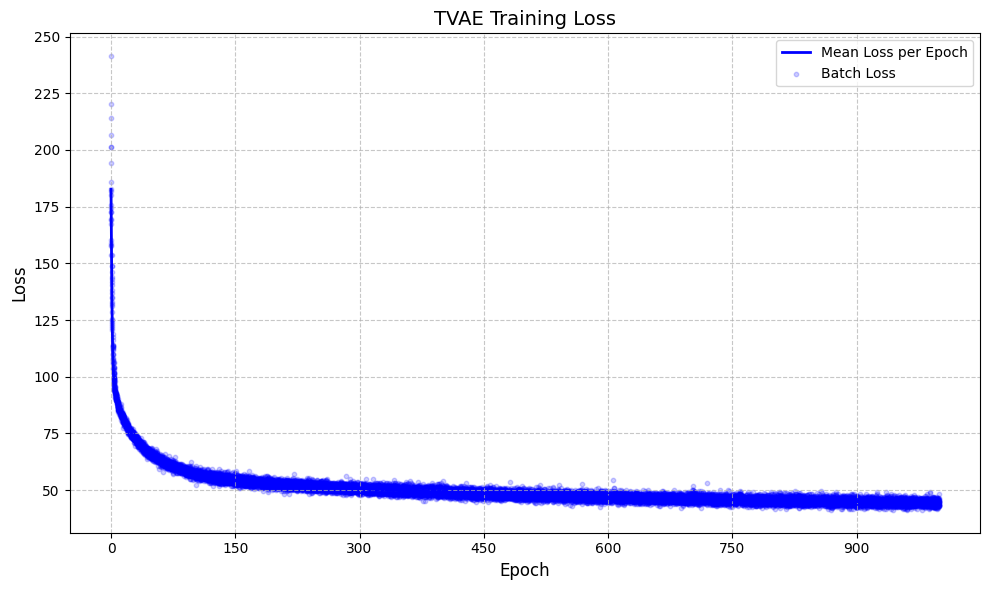

In [6]:
model.plot_loss(show_batch_loss=True);  # Note the semicolon

In [ ]:
synthetic_data = model.sample(len(rhc_data))

to implement a function to check if there is no identical value in my numerical columns between the data set orignal = rhc_data and the dataset synthetic = synthetic_data.
To identify the columns you can use the metadata.json file which describes the sdtypes (=numerical in our case) of my columns (the columns and their sdtype remain the same in the synthetic data).

Applying PCA to reduce dimensions from 41 to 30...
Explained variance ratio sum: 0.9096
Applying UMAP to reduce from 30 to 2 dimensions...


/home/mfacotti/martin/tVAE_Synth/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/mfacotti/martin/tVAE_Synth/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/mfacotti/martin/tVAE_Synth/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



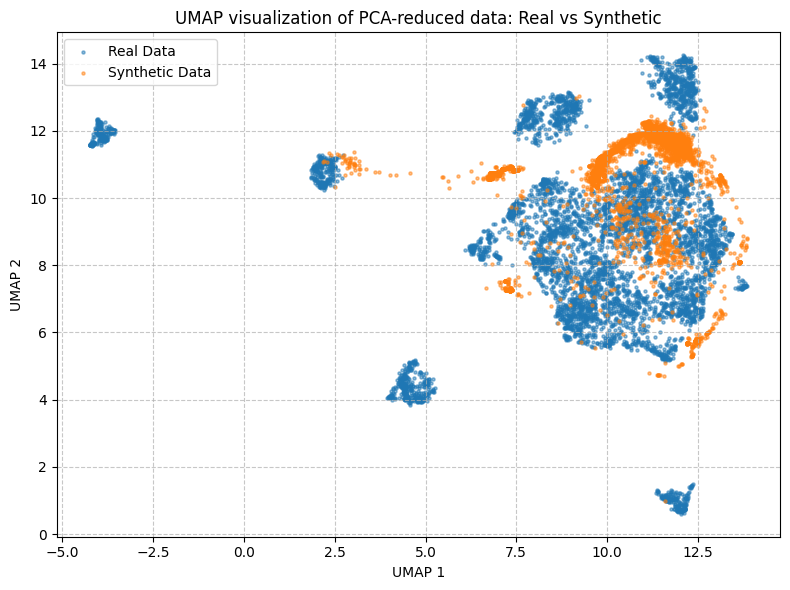

In [8]:
# Create a function to perform PCA followed by UMAP
def dimensionality_reduction_visualization(real_data, synthetic_data=None, n_components_pca=50, n_components_umap=2):
    """
    Performs PCA followed by UMAP and visualizes the results
    
    Parameters:
    -----------
    real_data: DataFrame
        The real dataset
    synthetic_data: DataFrame, optional
        The synthetic dataset to compare
    n_components_pca: int
        Number of PCA components to use (intermediate dimension)
    n_components_umap: int
        Number of UMAP components for final visualization
    """
    # Get only numerical columns
    numerical_cols = real_data.select_dtypes(include=['number']).columns
    
    # Prepare the data
    real_numerical = real_data[numerical_cols].copy()
    
    # Fill missing values for numerical processing
    real_numerical = real_numerical.fillna(real_numerical.mean())
    
    # Standardize the data
    scaler = StandardScaler()
    real_scaled = scaler.fit_transform(real_numerical)
    
    # Apply PCA first to reduce dimensions before UMAP
    print(f"Applying PCA to reduce dimensions from {real_scaled.shape[1]} to {n_components_pca}...")
    pca = PCA(n_components=min(n_components_pca, real_scaled.shape[1]))
    real_pca = pca.fit_transform(real_scaled)
    
    print(f"Explained variance ratio sum: {pca.explained_variance_ratio_.sum():.4f}")
    
    # Apply UMAP on the PCA results
    print(f"Applying UMAP to reduce from {real_pca.shape[1]} to {n_components_umap} dimensions...")
    reducer = umap.UMAP(n_components=n_components_umap, random_state=42)
    real_umap = reducer.fit_transform(real_pca)
    
    # Visualization
    plt.figure(figsize=(8, 6))
    
    if synthetic_data is not None:
        # Process synthetic data the same way
        synthetic_numerical = synthetic_data[numerical_cols].copy()
        synthetic_numerical = synthetic_numerical.fillna(synthetic_numerical.mean())
        synthetic_scaled = scaler.transform(synthetic_numerical)
        synthetic_pca = pca.transform(synthetic_scaled)
        synthetic_umap = reducer.transform(synthetic_pca)
        
        # Create plot with both datasets
        plt.scatter(real_umap[:, 0], real_umap[:, 1], s=5, alpha=0.5, label='Real Data')
        plt.scatter(synthetic_umap[:, 0], synthetic_umap[:, 1], s=5, alpha=0.5, label='Synthetic Data')
        plt.title('UMAP visualization of PCA-reduced data: Real vs Synthetic')
    else:
        # Only real data
        plt.scatter(real_umap[:, 0], real_umap[:, 1], s=5, alpha=0.5)
        plt.title('UMAP visualization of PCA-reduced data')
    
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return real_umap, pca, reducer

# Apply the function to your data
real_umap, pca_model, umap_model = dimensionality_reduction_visualization(
    real_data=rhc_data, 
    synthetic_data=synthetic_data,
    n_components_pca=30,
    n_components_umap=2
)

In [ ]:
# Color by a categorical feature
def plot_umap_with_category(umap_result, data, category_col):
    plt.figure(figsize=(8, 6))
    categories = data[category_col].unique()
    
    for category in categories:
        indices = data[category_col] == category
        plt.scatter(umap_result[indices, 0], umap_result[indices, 1], 
                   label=category, s=5, alpha=0.7)
    
    plt.title(f'UMAP colored by {category_col}')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example of usage (replace 'category_column' with an actual column name)
plot_umap_with_category(real_umap, rhc_data, 'cat1')

Variables catégorielles disponibles: ['cat1', 'cat2', 'ca', 'death', 'sex', 'dth30', 'swang1', 'dnr1', 'ninsclas', 'resp', 'card', 'neuro', 'gastr', 'renal', 'meta', 'hema', 'seps', 'trauma', 'ortho', 'race', 'income']


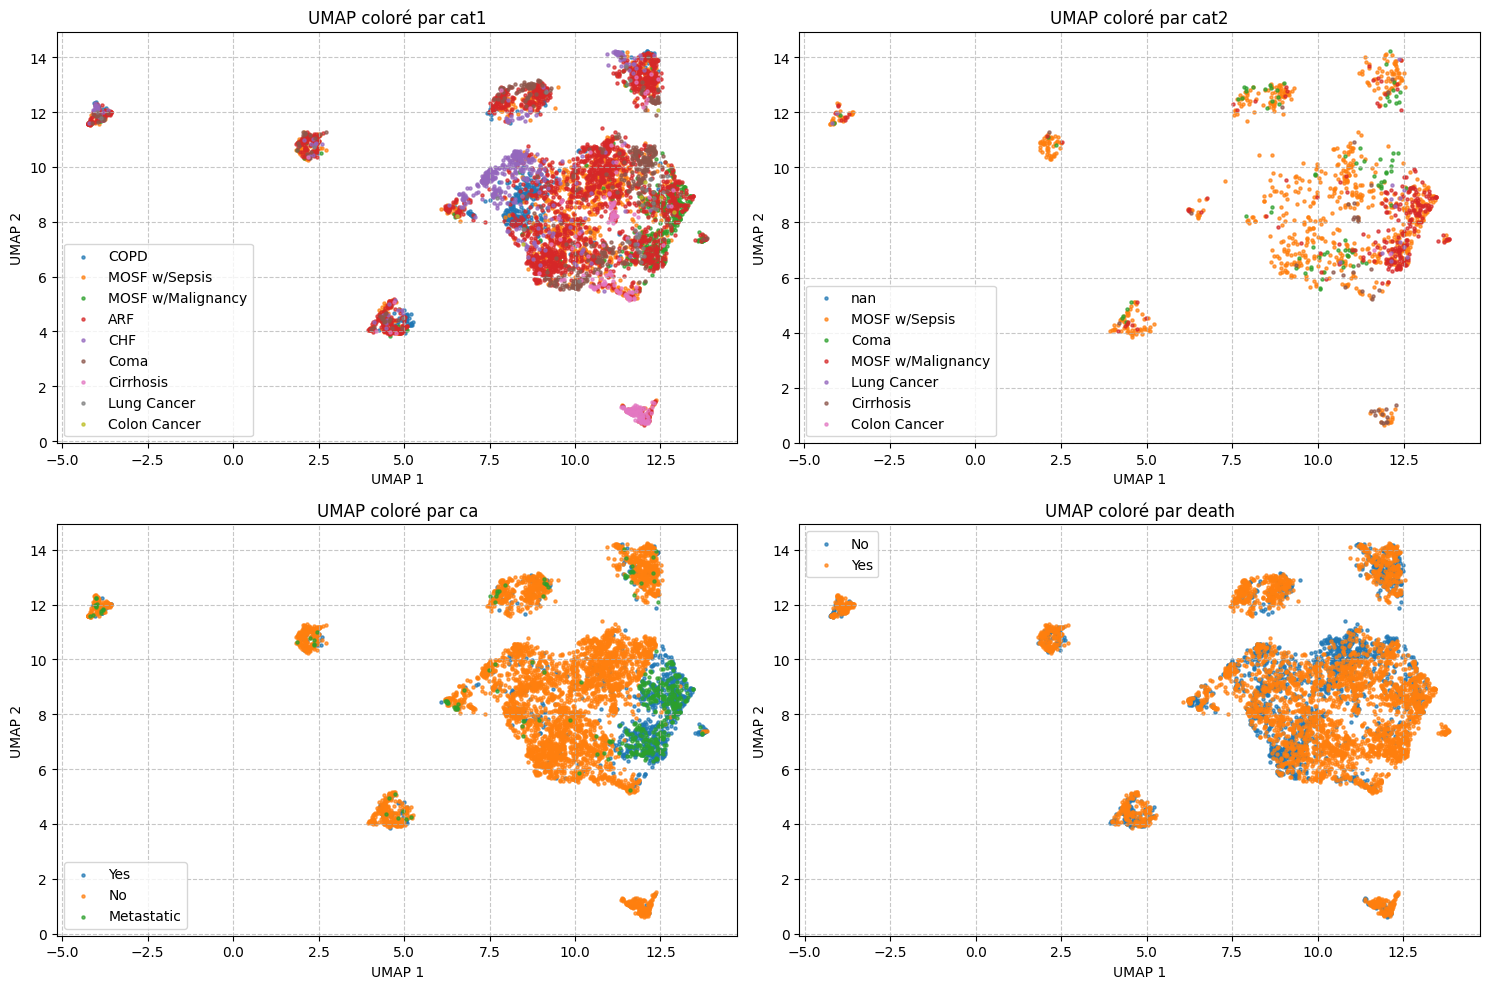

In [10]:
# Check the categorical variables in the dataset
categorical_columns = rhc_data.select_dtypes(include=['object', 'category']).columns
print(f"Variables catégorielles disponibles: {list(categorical_columns)}")

# create a subplot function to compare categorical variables
def compare_categorical_variables(umap_result, data, cat_vars, ncols=2):
    nrows = (len(cat_vars) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5*nrows))
    axes = axes.flatten()
    
    for i, cat_var in enumerate(cat_vars):
        if i < len(axes):
            categories = data[cat_var].unique()
            ax = axes[i]
            
            for category in categories:
                indices = data[cat_var] == category
                ax.scatter(umap_result[indices, 0], umap_result[indices, 1], 
                       label=category, s=5, alpha=0.7)
                
            ax.set_title(f'UMAP coloré par {cat_var}')
            ax.set_xlabel('UMAP 1')
            ax.set_ylabel('UMAP 2')
            ax.grid(True, linestyle='--', alpha=0.7)
            
            # Adjust legend position based on number of categories
            if len(categories) < 10:
                ax.legend()
            else:
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    plt.tight_layout()
    plt.show()

# Sélectionner les 4 premières variables catégorielles pour l'exemple
selected_cat_vars = list(categorical_columns)[:4] # or replace with your choice
compare_categorical_variables(real_umap, rhc_data, selected_cat_vars)

In [11]:
diagnostic = run_diagnostic(
    real_data=rhc_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 62/62 [00:00<00:00, 457.37it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 165.33it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [12]:
quality_report = evaluate_quality(
    rhc_data,
    synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 62/62 [00:00<00:00, 158.22it/s]|
Column Shapes Score: 91.26%

(2/2) Evaluating Column Pair Trends: |██████████| 1891/1891 [00:18<00:00, 102.86it/s]|
Column Pair Trends Score: 86.82%

Overall Score (Average): 89.04%



Missing Values Percentage Comparison:
         Real Data (%)  Synthetic Data (%)
cat2         79.075850           84.306888
adld3p       74.908457           80.714908
urin1        52.798605           52.746295
dthdte       35.100262           34.420227
dschdte       0.017437            0.017437


<Figure size 1400x800 with 0 Axes>

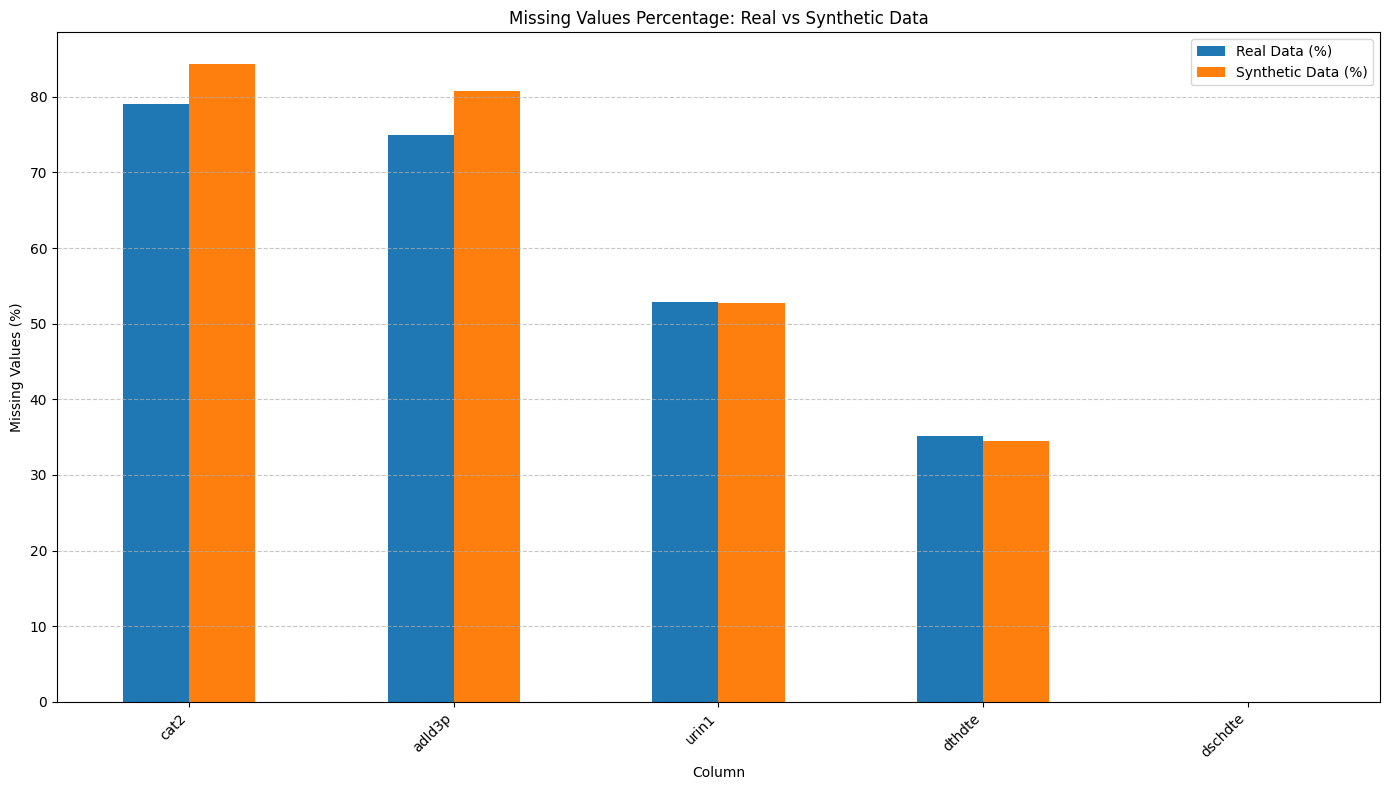

In [13]:
# Compare missing values percentage between real and synthetic data
missing_real = rhc_data.isna().mean().sort_values(ascending=False) * 100
missing_synthetic = synthetic_data.isna().mean().sort_values(ascending=False) * 100

# Filter only columns with missing values
missing_comparison = pd.DataFrame({
    'Real Data (%)': missing_real[missing_real > 0],
    'Synthetic Data (%)': missing_synthetic.reindex(missing_real[missing_real > 0].index)
})

# Display comparison
print("Missing Values Percentage Comparison:")
print(missing_comparison)

# Visualize the comparison
plt.figure(figsize=(14, 8))
missing_comparison.plot(kind='bar', figsize=(14, 8))
plt.title('Missing Values Percentage: Real vs Synthetic Data')
plt.ylabel('Missing Values (%)')
plt.xlabel('Column')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
model_name = 'tvae_ep1000_compress32'
model_filepath = f'test_model_{model_name}.pkl'

In [ ]:
model.save(
    filepath=model_filepath
)

In [ ]:
synthetic_data = model.sample(len(rhc_data))

In [ ]:
output_filename = f'synthetic_data_{model_name}.csv'
synthetic_data.to_csv(output_filename, index=False)